# Ejercicion de programación - Regresión Logistica

En este ejercicio se implementa regresion logistica y se aplica a dos diferentes datasets.

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
# se utiliza para el manejo de rutas y directorios.
import os

# Calculo cientifico y vectorial para python
import numpy as np

# Librerias para graficar
from matplotlib import pyplot

# Modulo de optimización de scipy
from scipy import optimize

# le dice a matplotlib que incruste gráficos en el cuaderno
%matplotlib inline

## 1 Regresion Logistica

En esta parte del ejercicio, creará un modelo de regresión logística para predecir si un estudiante será admitido en una universidad. Suponga que es el administrador de un departamento universitario y desea determinar las posibilidades de admisión de cada solicitante en función de sus resultados en dos exámenes. Tiene datos históricos de solicitantes anteriores que puede usar como un conjunto de capacitación para la regresión logística. Para cada ejemplo de capacitación, se tiene las calificaciones del solicitante en dos exámenes y la decisión de admisión. Su tarea es crear un modelo de clasificación que calcule la probabilidad de admisión de un solicitante en función de los puntajes de esos dos exámenes.

La siguiente celda cargará los datos y las etiquetas correspondientes:

In [40]:
# Cargar datos
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/IA/customer_purchase_data.csv', delimiter=',')

# data= data.drop('DiscountsAvailed', axis=1)# Para eliminar columnas

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 1500 non-null   int64  
 1   Gender              1500 non-null   int64  
 2   AnnualIncome        1500 non-null   float64
 3   NumberOfPurchases   1500 non-null   int64  
 4   ProductCategory     1500 non-null   int64  
 5   TimeSpentOnWebsite  1500 non-null   float64
 6   LoyaltyProgram      1500 non-null   int64  
 7   DiscountsAvailed    1500 non-null   int64  
 8   PurchaseStatus      1500 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 105.6 KB


Datos de Entrenamiento y de prueba

In [42]:
X = data.iloc[:1200, :-1] #entrenamiento 80%
X_test = data.iloc[1200:, :-1] # test 20%
y = data.iloc[:1200, data.columns.get_loc("PurchaseStatus")]#entrenamiento 80%
y_test = data.iloc[1200:, data.columns.get_loc("PurchaseStatus")]# test 20%

<a id="section1"></a>
### 1.2 Implementacion

#### 1.2.1 Fución Sigmoidea

La hipotesis para la regresión logistica se define como:

$$ h_\theta(x) = g(\theta^T x)$$

donde la función $g$ is la función sigmoidea. La función sigmoidea se define como:

$$g(z) = \frac{1}{1+e^{-z}}$$.

Los resultados que debe generar la funcion sigmoidea para valores positivos amplios de `x`, deben ser cercanos a 1, mientras que para valores negativos grandes, la sigmoide debe generar valores cercanos 0. La evaluacion de `sigmoid(0)` debe dar un resultado exacto de 0.5. Esta funcion tambien debe poder trabajar con vectores y matrices.

In [43]:
def sigmoid(z):
    # Calcula la sigmoide de una entrada z
    # convierte la intrada a un arreglo numpy
    z = np.array(z)
    #creamos un arreglo de ceros en g, de la misma cantidad de z
    g = np.zeros(z.shape)
    #calcula la funcion sigmoideal
    g = 1 / (1 + np.exp(-z))

    return g

Se calcula el valor de la sigmoide aplicando la funcion sigmoid con `z=0`, se debe obtener un resultado de 0.5. RE recomienda experimentar con otros valores de `z`.

In [44]:
# Prueba la implementacion de la funcion sigmoid
z = 0
g = sigmoid(z)

print('g(', z, ') = ', g)

g( 0 ) =  0.5


In [45]:
def decision(probabilidad):
  punto_corte = 0.5
  return np.where(probabilidad >= punto_corte, 1, 0)

In [46]:
def  featureNormalize(X):
    X_norm = X.copy()
    mu = np.zeros(X.shape[1])
    sigma = np.zeros(X.shape[1])

    mu = np.mean(X, axis = 0)
    sigma = np.std(X, axis = 0)
    X_norm = (X - mu) / sigma

    return X_norm, mu, sigma


In [47]:
# llama featureNormalize con los datos cargados
X_norm, mu, sigma = featureNormalize(X)

<a id="section2"></a>
#### 1.2.2 Función de Costo y Gradiente

Se implementa la funcion cost y gradient, para la regresión logistica. Antes de continuar es importante agregar el termino de intercepcion a X.

In [48]:
# Configurar la matriz adecuadamente, y agregar una columna de unos que corresponde al termino de intercepción.
m, n = X.shape
# Agraga el termino de intercepción a A
X = np.concatenate([np.ones((m, 1)), X_norm], axis=1)
# X = np.concatenate([np.ones((m, 1)), X], axis=1)

La funcion de costo en una regresión logistica es:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \left[ -y^{(i)} \log\left(h_\theta\left( x^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - h_\theta\left( x^{(i)} \right) \right) \right]$$

y el gradiente del costo es un vector de la misma longitud como $\theta$ donde el elemento $j^{th}$ (para $j = 0, 1, \cdots , n$) se define como:

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} $$

Si bien este gradiente parece idéntico al gradiente de regresión lineal, la fórmula es diferente porque la regresión lineal y logística tienen diferentes definiciones de $h_\theta(x)$.
<a id="costFunction"></a>

In [49]:
def calcularCosto(theta, X, y):
    # Inicializar algunos valores utiles
    m = y.size  # numero de ejemplos de entrenamiento

    J = 0
    h = sigmoid(X.dot(theta.T))
    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h)))

    return J

In [50]:
def descensoGradiente(theta, X, y, alpha, num_iters):
    # Inicializa algunos valores
    m = y.shape[0] # numero de ejemplos de entrenamiento

    # realiza una copia de theta, el cual será acutalizada por el descenso por el gradiente
    theta = theta.copy()
    J_history = []

    for i in range(num_iters):
        h = sigmoid(X.dot(theta.T))
        theta = theta - (alpha / m) * (h - y).dot(X)

        J_history.append(calcularCosto(theta, X, y))
    return theta, J_history

theta calculado por el descenso por el gradiente: [-0.46477475 -1.00210267  0.0320436   0.7344928   0.63319127 -0.08390967
  1.02328689  1.16684235  1.12227751]
Para verificar la compra, 1:compra, 0: no compra  (usando el descenso por el gradiente):1


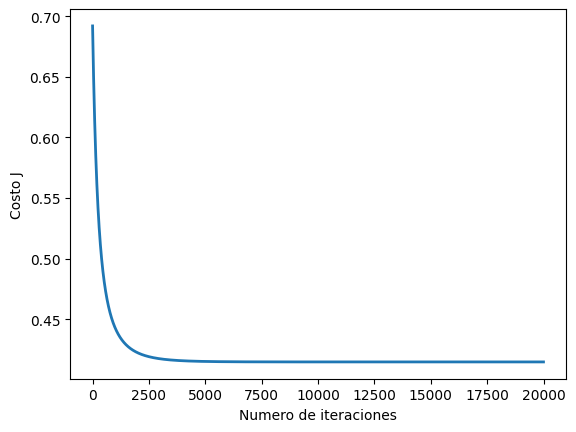

In [51]:
# Elegir algun valor para alpha (probar varias alternativas)
alpha = 0.01
num_iters = 20000

# inicializa theta y ejecuta el descenso por el gradiente
theta = np.zeros(9)
theta, J_history = descensoGradiente(theta, X, y, alpha, num_iters)

# Grafica la convergencia del costo
pyplot.plot(np.arange(len(J_history)), J_history, lw=2)
pyplot.xlabel('Numero de iteraciones')
pyplot.ylabel('Costo J')

# Muestra los resultados del descenso por el gradiente
print('theta calculado por el descenso por el gradiente: {:s}'.format(str(theta)))

# verifica si realiza compra o no compra
#----------------------
X_array = [1,27,1,127821.3064316501,11,2,31.633211501604148,1,0]
aprueba = sigmoid(np.dot(X_array, theta))

print('Para verificar la compra, 1:compra, 0: no compra  (usando el descenso por el gradiente):{:.0f}'.format(aprueba))

Se aplica en X_tes la facturalizacion y se agregan las columna de unos

In [52]:
X_test, mu, sigma = featureNormalize(X_test)
m, n = X_test.shape
X_test = np.concatenate([np.ones((m, 1)), X_test], axis=1)
aprueba = sigmoid(np.dot(X_test, theta))

# Test con el 20% de datos

In [53]:
probabilidad = sigmoid(np.dot(X_test, theta))
resultado = decision(probabilidad)
print(resultado)

[0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0 1 1 0 1 1 0 0 0 1 0
 0 0 0 1 1 0 1 0 1 0 0 0 1 1 0 1 1 1 1 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 1
 0 1 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 1 1 0 0 1 0 1 0 0 0 0 0
 0 0 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 0 1 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 1 0 1
 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 1 1 0 1 1 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 1 1 0 0 1 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 1 1 1 1 0 1 0 1 1 0 0 1
 0 1 1 1 0 0 1 0 0 0 1 0 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0
 1 1 0 1 0 1 1 0 0 0 1 0 1 1 1 1 0 0 1 0 1 1 1 1 1 0 0 0 0 1 1 0 1 0 0 0 1
 0 0 1 1]


In [54]:
def costFunction(theta, X, y):
    # Inicializar algunos valores utiles
    m = y_test.size  # numero de ejemplos de entrenamiento
    #Se define una pequeña cantidad epsilon para evitar problemas de logaritmo de cero en el cálculo de la función de costo
    epsilon = 1e-8

    J = 0
    grad = np.zeros(theta.shape)

    h = sigmoid(X_test.dot(theta.T))

    J = (1 / m) * np.sum(-y_test.dot(np.log(h+epsilon)) - (1 - y_test).dot(np.log(1 - h+epsilon)))
    grad = (1 / m) * (h - y_test).dot(X_test)

    return J, grad

Se prueba la funcion `costFunction` utilizando dos casos de prueba para $\theta$.

In [55]:
# Inicializacion de parametros de ajuste
initial_theta = np.zeros(n+1)
print(initial_theta)
cost, grad = costFunction(initial_theta, X, y)

print('Costo en theta inicial (zeros): {:.3f}'.format(cost))
print(grad)
print('Gradiente en theta inicial (zeros):')
print('\t[{:.2f}, {:.2f}, {:.2f},{:.2f}, {:.2f}, {:.2f}, {:.2f},{:.2f},{:.2f}]'.format(*grad))

[0. 0. 0. 0. 0. 0. 0. 0. 0.]
Costo en theta inicial (zeros): 0.693
[ 0.06666667  0.11395983  0.02556976 -0.0851127  -0.09963437  0.01820012
 -0.15464342 -0.14358162 -0.18865614]
Gradiente en theta inicial (zeros):
	[0.07, 0.11, 0.03,-0.09, -0.10, 0.02, -0.15,-0.14,-0.19]


In [56]:
# Calcula y muestra el costo y el gradiente con valores de theta diferentes a cero

test_theta = np.array(X[1])

print(test_theta)
cost, grad = costFunction(test_theta, X, y)

print('Costo en theta prueba: {:.3f}'.format(cost))

print('Gradiente en theta prueba:')
print('\t[{:.2f}, {:.2f}, {:.2f},{:.2f}, {:.2f}, {:.2f}, {:.2f},{:.2f},{:.2f}]'.format(*grad))

[ 1.         -1.54621154  0.98019606 -1.61478117 -1.08419782 -0.01935655
  0.44389142 -0.68468113  1.42389689]
Costo en theta prueba: 1.393
Gradiente en theta prueba:
	[0.18, -0.05, 0.14,-0.27, -0.20, 0.00, -0.12,-0.20,-0.05]


#### 1.2.3 Parámetros de aprendizaje usando `scipy.optimize`

En el codigo anterior se encontró los parámetros óptimos de un modelo de regresión lineal al implementar el descenso de gradiente. Se implemento una función de costo y se calculó su gradiente, utilizando el algoritmo del descenso por el gradiente.

En lugar de realizar los pasos del descenso por el gradiente, se utilizará el [módulo `scipy.optimize`] (https://docs.scipy.org/doc/scipy/reference/optimize.html). SciPy es una biblioteca de computación numérica para `python`. Proporciona un módulo de optimización para la búsqueda y minimización de raíces. A partir de `scipy 1.0`, la función` scipy.optimize.minimize` es el método a utilizar para problemas de optimización (tanto restringidos como no restringidos).

For logistic regression, you want to optimize the cost function $J(\theta)$ with parameters $\theta$.
Concretely, you are going to use `optimize.minimize` to find the best parameters $\theta$ for the logistic regression cost function, given a fixed dataset (of X and y values). You will pass to `optimize.minimize` the following inputs:

Para la regresión logística, se desea optimizar la función de costo $J(\theta)$ con los parámetros $\theta$.
Concretamente, se va a utilizar `optimize.minimize` para encontrar los mejores parámetros $\theta$ para la función de costo de regresión logística, dado un dataset fijo (de valores X e y). Se pasara a `optimize.minimize` las siguientes entradas:

- `costFunction`: Una función de costo que, cuando se le da el dataset de entrenamiento y un $\theta$ particular, calcula el costo de regresión logística y el gradiente con respecto a $\theta$ para el dataset(X, y). Es importante tener en cuenta que solo se pasa el nombre de la función sin el paréntesis. Esto indica que solo proporcionamos una referencia a esta función y no evaluamos el resultado de esta función.
- `initial_theta`: Los valores iniciales de los parametros que se tratan de optimizar.
- `(X, y)`: Estos son argumentos adicionales a la funcion de costo.
- `jac`: Indicación si la función de costo devuelve el jacobiano (gradiente) junto con el valor de costo. (True)
- `method`: Método / algoritmo de optimización a utilizar
- `options`: Opciones adicionales que pueden ser específicas del método de optimización específico. Solo se indica al algoritmo el número máximo de iteraciones antes de que termine.

Si se ha completado la `costFunction` correctamente,`optimize.minimize` convergerá en los parámetros de optimización correctos y devolverá los valores finales del costo y $\theta$ en un objeto de clase.

Al usar `optimize.minimize`, no se tuvo que escribir ningún bucle ni establecer una tasa de aprendizaje como se hizo para el descenso de gradientes. Todo esto se hace mediante `optimize.minimize`: solo se necesita proporcionar una función que calcule el costo y el gradiente.

A continuación, se tiene el código para llamar a `optimize.minimize` con los argumentos correctos.

In [57]:
# Establecer las opciones para optimize.minimize
options= {'maxiter': 1000}

# revisar la documentacion de scipy's optimize.minimize para mayor descripcion de los parametros
# La funcion devuekve un objeto `OptimizeResult`
# Se utiliza el algoritmo de Newton truncado para la optimización.
res = optimize.minimize(costFunction,
                        initial_theta,
                        (X, y),
                        jac=True,
                        method='TNC',
                        options=options)

# la propiedad fun del objeto devuelto por `OptimizeResult`
# contiene el valor del costFunction de un theta optimizado
cost = res.fun

# Theta optimizada esta en la propiedad x
theta = res.x

# Imprimir theta en la pantalla
print('Costo con un valor de theta encontrado por optimize.minimize: {:.3f}'.format(cost))

print('theta:')
print('\t[{:.3f}, {:.3f}, {:.3f},{:.3f}, {:.3f}, {:.3f},{:.3f}, {:.3f}, {:.3f}]'.format(*theta))

Costo con un valor de theta encontrado por optimize.minimize: 0.395
theta:
	[-0.521, -0.959, -0.005,0.715, 0.689, -0.086,1.183, 1.017, 1.390]


<ipython-input-57-a25fe8a4e925>:7: OptimizeWarning: Unknown solver options: maxiter
  res = optimize.minimize(costFunction,


<a id="section4"></a>
#### 1.2.4 Evaluación de la regresión logistica

Después de aprender los parámetros, se puede usar el modelo para predecir si un estudiante en particular será admitido. Para un estudiante con una puntuación en el Examen 1 de 45 y una puntuación en el Examen 2 de 85, debe esperar ver una probabilidad de admisión de 0,776. Otra forma de evaluar la calidad de los parámetros que hemos encontrado es ver qué tan bien predice el modelo aprendido en nuestro conjunto de entrenamiento.

In [58]:
# def predict(theta, X):
#     m = X.shape[0] # Numero de ejemplo de entrenamiento

#     p = np.zeros(m)

#     p = np.round(sigmoid(X.dot(theta.T)))
#     return p
def predict(theta, X_test):
    #devuelve el tamaño del primer eje de la matriz
    m = X_test.shape[0] # Numero de ejemplo de entrenamiento
    #Esta línea inicializa un vector p de tamaño m con ceros
    p = np.zeros(m)
    #Esta línea realiza las predicciones utilizando la función sigmoide y el producto punto entre X_test y theta.T
    p = np.round(sigmoid(X_test.dot(theta.T)))
    return p

Una vez entrenado el modelo se procede a realizar la prediccion y evaluación de los resultados de predecir cual es el valor que vota el modelo para todos los datos utilizados en el entrenamiento.

In [59]:
#  Predice la probabilidad de compra de en un supermecado
prob = sigmoid(np.dot([1,19,1,107485.66091127621,7,1,28.26032122753378,1,4], theta))
print('Para verificar la compra, 1:compra, 0: no compra  {:.3f}%'.format(prob))
print('Con estos datos la prediccion es: {:.0f}'.format(prob))

p = predict(theta, X_test)
# Esta línea calcula la precisión en el conjunto de prueba comparando las predicciones p
# con las etiquetas reales y_test. La función np.mean(p == y_test) calcula la proporción
# de predicciones correctas, y se multiplica por 100 para obtener el porcentaje de precisión.
# La precisión se imprime utilizando el formato '{:.2f}' para mostrar dos decimales.
print('Precisión de entrenamiento: {:.2f} %'.format(np.mean(p == y_test) * 100))

Para verificar la compra, 1:compra, 0: no compra  1.000%
Con estos datos la prediccion es: 1
Precisión de entrenamiento: 82.67 %
